# DATASET과 DATALOADER
<hr/>

dataset code는 가독성(readability)와 모듈성(modularity)를 위해 모델 학습 코드로부터 분리하는 것이 이상적.

PyTorch는 torch.utils.data.DataLoader 와 torch.utils.data.Dataset 의 두가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있게 함.

DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 iterable 객체로 감쌈.

데이터셋은 torch.utils.data.Dataset의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다.
이러한 데이터셋은 모델을 만들어보고 성능을 측정하는데 사용이 가능하다.


# Dataset 불러오기
<hr/>

TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제.

Fashion-MNIST
- Zalando의 기사 이미지 데이터셋으로 60,000개의 training set과 10,000개의 test set으로 이루어져 있다.
- grayscale 28 * 28 image
- Label : 10개의 class 중 하나인 정답 label
<hr/>

다음 매개 변수들을 사용하여 FashionMNIST dataset을 불러온다.

- root : training/test data 가 저장되는 경로
- train : train용인지 test용인지 여부를 결정
- download=True : root에 데이터가 없는 경우 인터넷에서 다운로드
- transform / target_transform : feature와 label transform 을 지정한다.

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# 데이터셋을 순회하고 시각화하기

Dataset에 리스트처럼 직접 접근할 수 있습니다. (indexing)
training_data[index], matplotlib을 사용하여 학습 데이터 일부 시각화하기

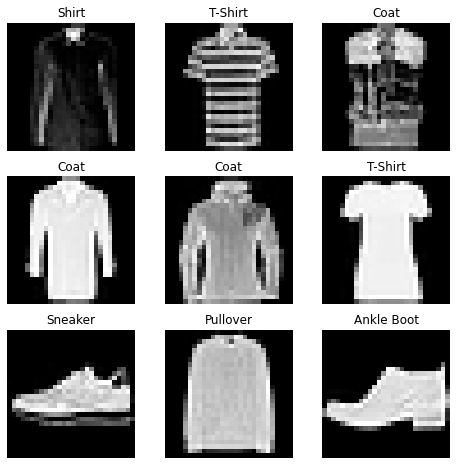

In [7]:
labels_map={
    0: 'T-Shirt',
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()
    

# 파일에서 사용자 정의 데이터셋 만들기
<hr/>

사용자 Dataset 클래스는 반드시 3개의 함수를 구현해야한다.
- __inint__
- __len__
- __getitem__

모든 만들어지는 dataset은 Dataset의 subclass로 작성되어야 한다.

FashionMNIST 이미지들 -> img_dir
Label -> annotations_file의 csv파일

In [8]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # .iloc[idx, 0]은 index로 데이터프레임의 행이나 컬럼에 접근
        # .loc 는 데이터프레임의 행이나 컬럼에 boolean array로 접근
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label


# &#95;&#95;init&#95;&#95; 함수

&#95;&#95;init&#95;&#95; 함수는 Dataset 객체 생성(initiate) 시 한번만 생성.

여기서는 image, annotation_file이 포함된 디렉토리와 2가지 transform을 초기화

labels.csv는 다음과 같은 형식으로 나타난다.
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

# &#95;&#95;len&#95;&#95;

&#95;&#95;len&#95;&#95; 함수는 데이터셋의 샘플 개수를 반환합니다.

In [ ]:
def __len__(self):
    return len(self.img_labels)

# &#95;&#95;getitem&#95;&#95;

&#95;&#95;getitem&#95;&#95; 함수는 주어진 인덱스(idx)에 해당하는 샘플을 데이터셋에서 불러오고 반환.

인덱스를 기반으로, 이미지의 위치를 식별
read_image를 사용하여 이미지를 텐서로 변환 (image -> tensor)
self.img_labels 의 csv 데이터에서 label을 가져오고, 해당하는 경우 transform 적용 뒤, 텐서image와 label을 dictionary 형태로 반환

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

# DataLoader로 학습용 데이터 준비하기

Dataset은 데이터셋의 feature를 가져오고 하나의 샘플에 label을 지정하는 일을 한번에 한다.

모델을 학습 시, 샘플을 minibatch로 전달하고, 매 epoch 마다 데이터를 다시 섞어서 overfit을 막고, python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 한다.

DataLoader는 간단한 API로 복잡한 과정들을 추상화한 iterable 객체이다.

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# DataLoader를 통해 iterate 하기

DataLoader에 데이터셋을 불러온 뒤에는 데이터셋을 순회할 수 있음.

train_features 와 train_labels 의 묶음(batch)를 반환
shuffle=True 이므로 모든 배치를 순회한 뒤 데이터가 섞임.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


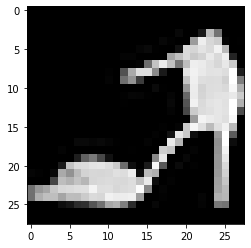

Label: 5


In [19]:
# 이미지와 label을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap='gray')
plt.show()

print(f'Label: {label}')